# Исследование оттока клиентов фитнес-центра

Цель исследования - провести анализ данных по клиентам и подготовить план действий по их удержанию

Исходные данные - данные из анкет клиентов фитнес-центра с фактом оттока

Вопросы, на которые нужно ответить:

1. Прогноз вероятности оттока
2. Типичные портреты клиентов
3. Какие признаки оказывают наибольшее влияние на отток?
4. Какие целевые группы клиентов, на которых стоит сфокусировать действия по удержанию?
5. Какие меры могут снизить отток?

Основные шаги исследования:

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Построение модели прогнозирования оттока клиентов
4. Проведение кластеризации клиентов
5. Формулировка выводов и рекомендация

**Описание данных**

Данные представлены в виде таблицы в фомрмате `csv`. Данные составлены из двух частей - данные клиентов и данные на основе журнала посещений.

**Столбцы таблицы**:

- `Churn` — факт оттока в текущем месяце;

**Данные клиента за предыдущий до проверки факта оттока месяц**:

- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр; -'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента**:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#чтение файла
try:
    df = pd.read_csv('/datasets/gym_churn.csv', sep=',')
except:
    path = 'C:/Users/HP/'
    df = pd.read_csv(path + 'gym_churn.csv')

display(df.head())
display(df.info())   

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

## Исследование и предобработка

Разберем, что мы имеем на данный момент:
- пропусков в данных не обнаружено
- есть категориальные переменные: Gender, Contract_period.
- есть логические переменные: Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn

Данные представлены в числовом формате, так что использование линейной регресии может быть проблематично при обучении модели. Но задача оттока клиентов - бинарная классификация и их кластеризации к таким моделям отношения не имеют.

Проверим таблицу на дубликаты.

In [3]:
# проверка на дубликаты
print('Количество дубликатов в таблице:', df.duplicated().sum())

Количество дубликатов в таблице: 0


Посмотрим на значения, которые содержит наш датасет. Через функцию со списком выведем уникальные значения по каждому столбцу.

In [4]:
#просмотр уникальных значений
def unique(df):
    for col in df:
        print('Уникальные значения:', col)
        display(df[col].value_counts())

unique(df)

Уникальные значения: gender


1    2041
0    1959
Name: gender, dtype: int64

Уникальные значения: Near_Location


1    3381
0     619
Name: Near_Location, dtype: int64

Уникальные значения: Partner


0    2053
1    1947
Name: Partner, dtype: int64

Уникальные значения: Promo_friends


0    2766
1    1234
Name: Promo_friends, dtype: int64

Уникальные значения: Phone


1    3614
0     386
Name: Phone, dtype: int64

Уникальные значения: Contract_period


1     2207
12     960
6      833
Name: Contract_period, dtype: int64

Уникальные значения: Group_visits


0    2351
1    1649
Name: Group_visits, dtype: int64

Уникальные значения: Age


29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: Age, dtype: int64

Уникальные значения: Avg_additional_charges_total


14.227470     1
17.082321     1
278.204461    1
120.457631    1
130.711299    1
             ..
92.329635     1
147.615388    1
24.923561     1
56.129880     1
178.861814    1
Name: Avg_additional_charges_total, Length: 4000, dtype: int64

Уникальные значения: Month_to_end_contract


1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: Month_to_end_contract, dtype: int64

Уникальные значения: Lifetime


1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
15     24
14     24
16     15
17     11
20      7
19      7
18      7
21      5
23      2
24      2
26      2
22      2
31      1
27      1
29      1
Name: Lifetime, dtype: int64

Уникальные значения: Avg_class_frequency_total


0.000000    88
0.020398     1
2.182034     1
1.976985     1
1.671952     1
            ..
0.999179     1
1.734371     1
1.783444     1
3.791391     1
1.101832     1
Name: Avg_class_frequency_total, Length: 3913, dtype: int64

Уникальные значения: Avg_class_frequency_current_month


0.000000    181
1.328134      1
2.628932      1
1.797684      1
1.524367      1
           ... 
2.359231      1
2.461782      1
0.671450      1
1.047047      1
1.035270      1
Name: Avg_class_frequency_current_month, Length: 3820, dtype: int64

Уникальные значения: Churn


0    2939
1    1061
Name: Churn, dtype: int64

Можно отметить следующие моменты:

1. в выборке примерно равное распределение полов
2. среди клиентов преобладают те, кто живет рядом
3. примерно половина клиентов - сотрудники компаний-партнеров
4. преобладают клиенты, которые приходят сами, без использования промокода от друзей, знакомых
5. большинство клиентов указали свой телефон
6. большинство абонементов - месячные
7. больше половины клиентов посещают групповые занятия
8. возраст клиентов - от 18 до 41 года
9. примерно четверть клиентов из выборки перестала пользоваться услугами в текущем месяце

Сгруппируем данные по признаку оттока и посчитаем среднее по всем полям.

In [5]:
df_grouped = df.groupby('Churn').mean()
display(df_grouped)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


При сравнении признаков между оставшимися и выбывшими клиентами видно:

Пол, наличие телефона, возраст практически не влияет на отток - по первым двум признакам 0,51 и 0,9 соответственно у обеих групп, пол - 27 - 30 лет - мало отличается.

Какие факторы влияют на отток (из них можно будет составить матрицу признаков)?

1. Удаленность от фитнес-центра
2. Посещение по партнерской программе
3. Период действия абонемента
4. Посещение групповых программ
5. Доп.услуги
6. Месяцы до окончания абонемента
7. Время с момента первого посещения
8. Среднее кол-во посещений в неделю
9. Среднее кол-во посещений в месяц

Построим гистограммы по каждому признаку. Сделаем это автоматически с помощью списка.

GENDER


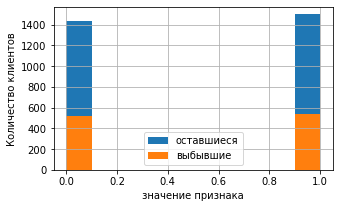

NEAR_LOCATION


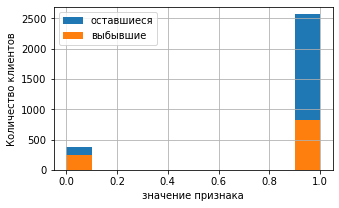

PARTNER


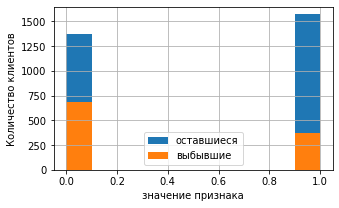

PROMO_FRIENDS


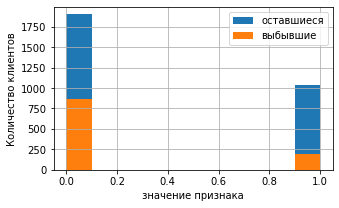

PHONE


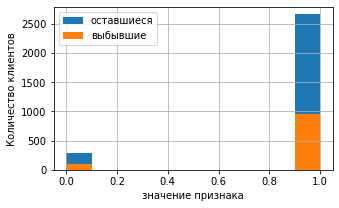

CONTRACT_PERIOD


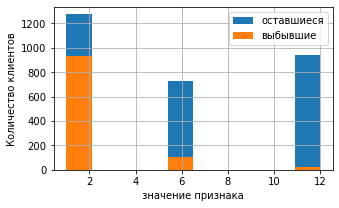

GROUP_VISITS


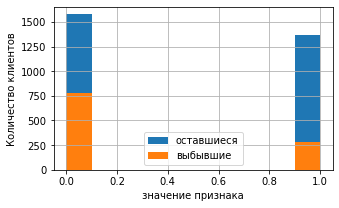

AGE


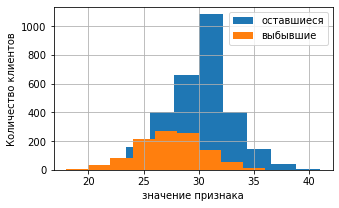

AVG_ADDITIONAL_CHARGES_TOTAL


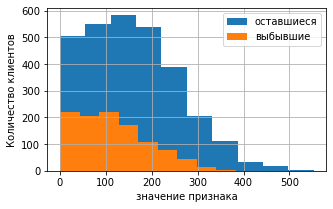

MONTH_TO_END_CONTRACT


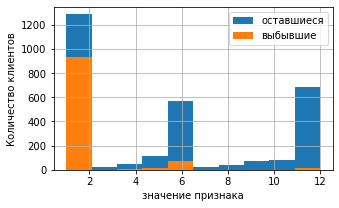

LIFETIME


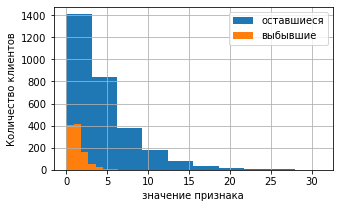

AVG_CLASS_FREQUENCY_TOTAL


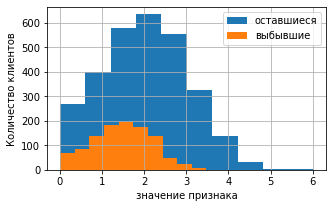

AVG_CLASS_FREQUENCY_CURRENT_MONTH


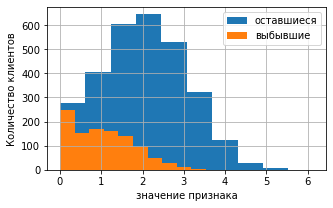

CHURN


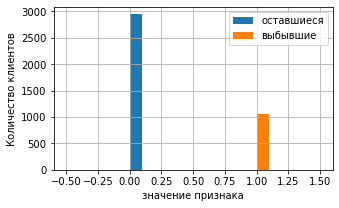

In [6]:
for column in df.columns:
        print(column.upper())
        fig = plt.figure(figsize=(5,3))
        df.query('Churn == 0')[column].hist(bins=10, label='оставшиеся')
        df.query('Churn == 1')[column].hist(bins=10, label='выбывшие')
        plt.ylabel('Количество клиентов')
        plt.xlabel('значение признака')
        plt.legend()
        plt.show()

Что можно увидеть у выбывших клиентов на основе частотных гистограмм:

- больше клиентов живут не в районе фитнес-центра
- больше клиентов не являются сотрудниками компаний-партнеров
- меньше клиентов пришли по промокоду друзей
- большинство клиентов покупают месячные абонементы
- меньше клиентов посещают групповые занятия
- у большинства клиентов до окончания остался месяц
- большинство клиентов посещают центр не дольше одного месяца после первого посещения
- диапазон среднего кол-ва посещений в неделю от 0 до 3.5 - меньше, чем у не выбывших (от 0 до 6)
- относительное большинство клиентов не посещает центр в последний месяц (0 посещений в неделю за текущий месяц)

Построим матрицу корреляций с Heatmap'ом.

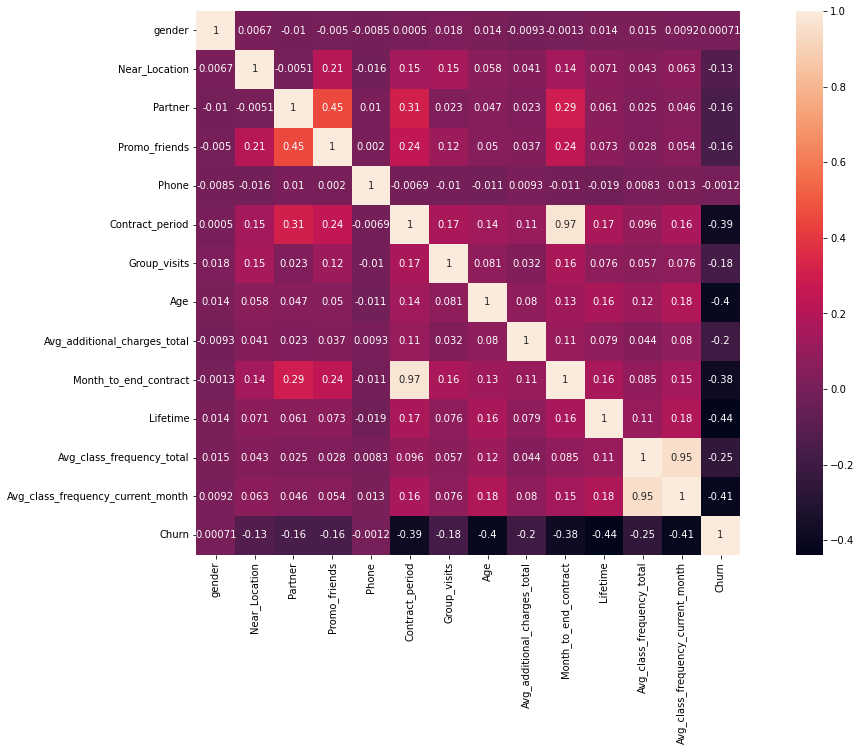

In [7]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm, annot=True, square=True) #ваш код здесь
plt.show()

На лицо сильная корреляция у некоторых признаков:
- Кол-во месяцев до окончания абонемента и срок действия абонемента - чем больше срок, тем больше будет наблюдений с бОльшим сроком до окончания
- Среднее кол-во посещений в неделю и среднее кол-во посещений за неделю в текущий месяц - скорее все те, у кого уже сформировался график посещений будут ходить в текущий месяц с той же частотой

Очевидна мультиколлинеарность, это может повлиять в частности на логистическую регрессию, поэтому для ее корректной работы удалим один признак у каждой пары.

In [8]:
df_for_model = df.drop(['Month_to_end_contract', 'Avg_class_frequency_total'], axis = 1)
display(df_for_model.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


В результате исследовательского анализа были выявлены бинарные и небинарные признаки, были выявлены **характерные** для выбывших клиентов признаки. Были выявлены и удалены сильно коррелирующие признаки.

## Модель прогнозирования оттока

Для дальнейшей работы выберем лучшую модель. Создадим список моделей и сравним их по трем параметрам - `accuracy`, `precision` и `recall`.

In [9]:
# разделение датафрейма на целевую переменную и обучающие признаки
X = df_for_model.drop(['Churn'], axis = 1)
y = df_for_model['Churn']
# разделяем выборку на обучающую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# формируем список моделей классификации
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    DecisionTreeClassifier(random_state=0),
]

In [11]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
        )
    )
    return y_pred

С помощью написанной выше функции сравним параметры моделей и выберем лучшую.

In [12]:
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(random_state=0, solver='liblinear')
accuracy:0.90 precision:0.79 recall:0.79
DecisionTreeClassifier(random_state=0)
accuracy:0.86 precision:0.69 recall:0.77


Основываясь на результатах сравнения будем использовать модель Логистической регрессии, так как она отличается более высокими показателями точности и попадания.

## Кластеризация

In [13]:
# Стандартизация данных
scaler = StandardScaler()
# стандартизируем признаки
df_sc = df.drop(['Churn'], axis = 1)
df_sc[['Age','Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']] = scaler.fit_transform(df_sc[['Age','Lifetime', 'Contract_period', 'Month_to_end_contract', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month', 'Avg_additional_charges_total']])
x_sc = df_sc
x_sc.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,0.289890,1,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,0,1,0,0,1,1.608822,1,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,0,1,1,0,1,-0.809219,0,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,0,1,1,1,1,1.608822,1,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,1,1,1,1,1,-0.809219,0,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


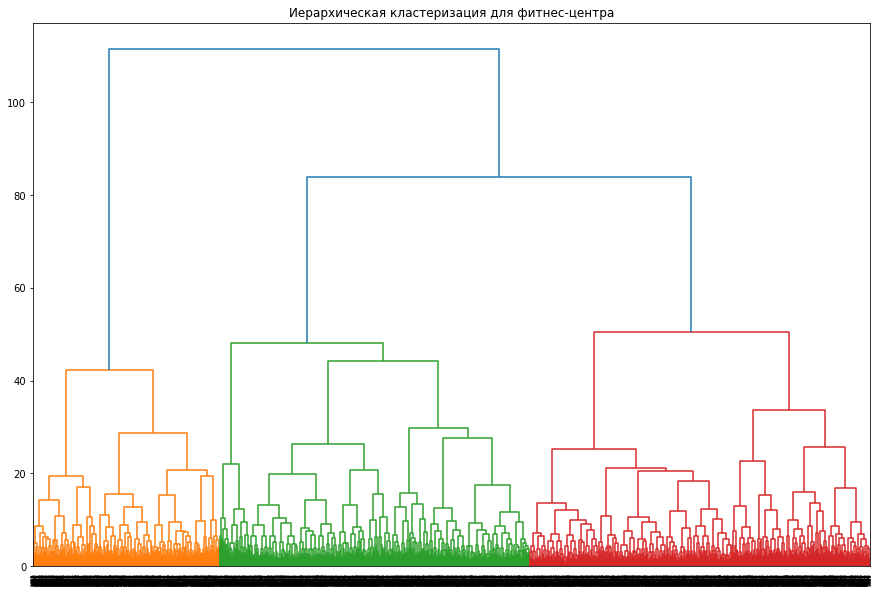

In [14]:
# сохраняем таблицу связок между объектами
linked = linkage(x_sc, method = 'ward')
# рисуем дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для фитнес-центра')
plt.show()

На основе дендрограммы по цвету можно выделить 3 кластера, также можно выбрать третий уровень - 5 кластеров, выбираем 5, для большей уверенности.

In [15]:
# обучаем модель KMeans
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# группируем клиентов по кластерам, признаку оттока и средним значениям
df_grouped2 = df.groupby(['cluster_km', 'Churn']).mean()
df_grouped2 = df_grouped2.reset_index()
display(df_grouped2)

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0,0.524752,0.909241,0.673267,0.448845,0.896040,9.415842,0.506601,30.095710,167.320409,8.706271,3.676568,0.992248,0.995506
1,0,1,0.653061,0.897959,0.693878,0.387755,0.918367,7.836735,0.346939,27.653061,150.253404,7.428571,1.061224,1.048067,0.582747
2,1,0,0.525708,0.848898,0.430220,0.295908,0.907660,2.748164,0.423924,30.272823,160.238659,2.627492,3.720881,2.815228,2.823357
3,1,1,0.504425,0.796460,0.327434,0.185841,0.902655,1.840708,0.300885,28.230088,129.325090,1.796460,0.946903,2.532596,2.345228
4,2,0,0.527027,0.871622,0.452703,0.297297,0.861486,3.550676,0.459459,29.976351,148.608957,3.222973,12.635135,1.856308,1.864625
5,2,1,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,33.000000,208.071672,1.000000,8.000000,1.974417,1.518766
6,3,0,0.480695,0.810811,0.401544,0.231660,0.915058,1.395753,0.401544,29.318533,145.247090,1.305019,3.270270,1.164328,1.158573
7,3,1,0.502247,0.757303,0.337079,0.171910,0.902247,1.286517,0.259551,26.800000,111.377315,1.248315,0.983146,1.355323,0.896975
8,4,0,0.485866,0.932862,0.724382,0.489399,0.916961,12.000000,0.545936,29.952297,163.148591,10.807420,4.664311,2.675451,2.674803
9,4,1,0.625000,0.750000,0.750000,0.250000,0.875000,12.000000,0.250000,25.750000,99.115188,10.625000,1.125000,2.402377,1.858820


Что можно выделить из полученного датасета?
- Почти во всех кластерах среди выбывших больше тех, кто живет не в районе центра;
- Во всех кластерах среди выбывших преобладают те, кто пришел сам, а не по промокоду;
- Почти во всех кластерах, кроме 4 длительность абонемента у выбывших ниже;
- Во всех кластерах у выбывших до конца абонемента остается меньше месяцев;
- Во всех кластерах lifetime у выбывших меньше, чем у оставшихся;
- Почти во всех кластерах выбывшие тратят на доп.услуги меньше, чем оставшиеся;
- Во всех кластерах у выбывших падает частота посещений в неделю в текущем месяце.

In [16]:
def hist_func(df, query_pam1):
    for column in df.columns:
        print(column.upper())
        fig = plt.figure(figsize=(5,3))
        df.query(query_pam1)[column].hist(bins=15)
        plt.ylabel('кол-во клиентов')
        plt.xlabel('значение признака')
        plt.show()

### Кластер 0

GENDER


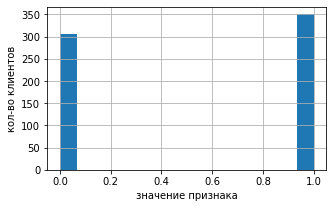

NEAR_LOCATION


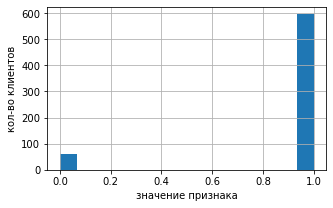

PARTNER


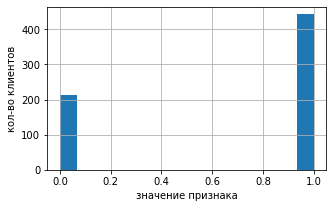

PROMO_FRIENDS


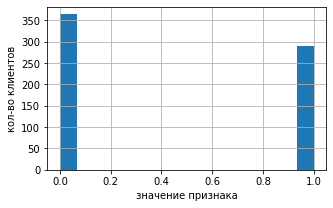

PHONE


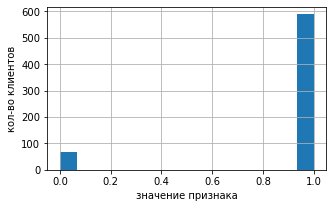

CONTRACT_PERIOD


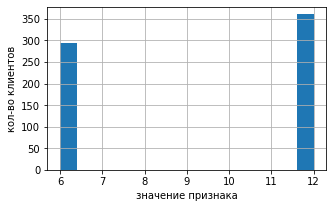

GROUP_VISITS


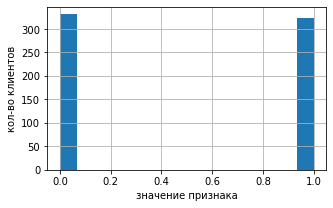

AGE


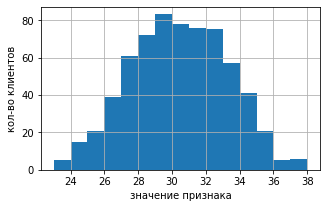

AVG_ADDITIONAL_CHARGES_TOTAL


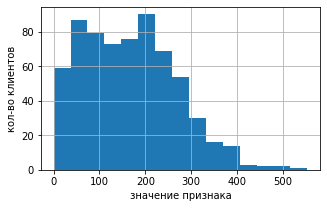

MONTH_TO_END_CONTRACT


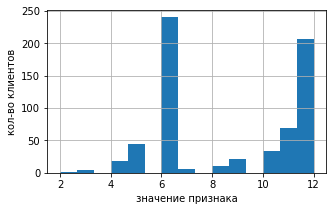

LIFETIME


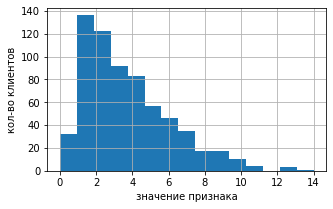

AVG_CLASS_FREQUENCY_TOTAL


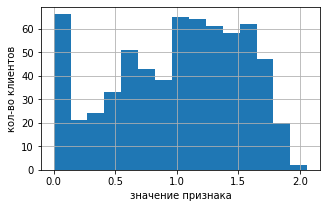

AVG_CLASS_FREQUENCY_CURRENT_MONTH


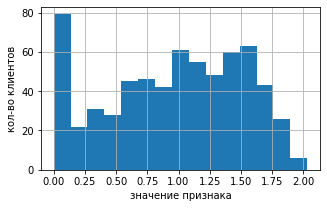

CHURN


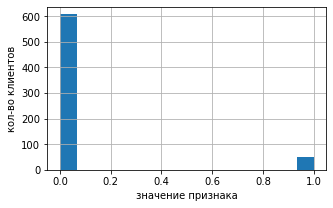

CLUSTER_KM


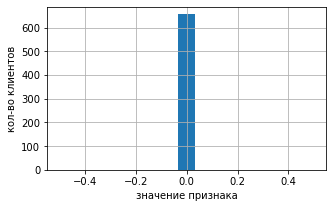

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,0,0.524752,0.909241,0.673267,0.448845,0.896040,9.415842,0.506601,30.095710,167.320409,8.706271,3.676568,0.992248,0.995506
1,0,1,0.653061,0.897959,0.693878,0.387755,0.918367,7.836735,0.346939,27.653061,150.253404,7.428571,1.061224,1.048067,0.582747


In [17]:
hist_func(df, 'cluster_km == 0')
df_grouped2_0 = df_grouped2.query('cluster_km == 0')
display(df_grouped2_0)

Что можно сказать по кластеру 0:
- скорее сотрудник, чем обычный клиент;
- скорее приходит без промокода, но различия незначительные;
- берет абонемент на 6 или 12 мес.;
- до окончания контракта в большинстве случаев осталось 6 или 12 мес.;
- менее 2 месяцев, высокая доля тех, кто не ходит;
- менее 2 месяцев, высокая доля тех, кто не ходит в неделю в текущем месяце, высокая доля тех, кто не ходит.

Кластер не выглядит показательным в плане сильного оттока. Посмотрим на остальные.

### Кластер 1

GENDER


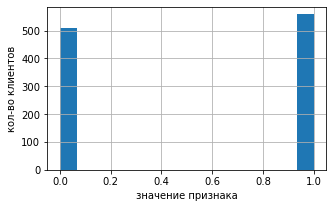

NEAR_LOCATION


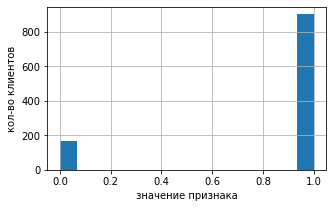

PARTNER


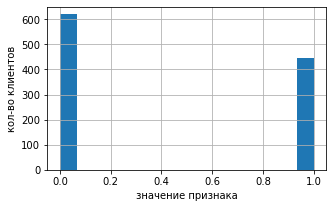

PROMO_FRIENDS


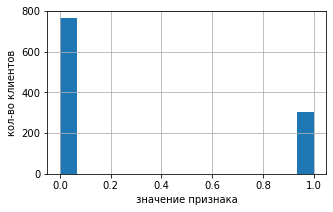

PHONE


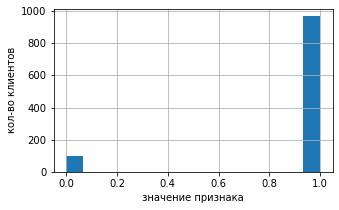

CONTRACT_PERIOD


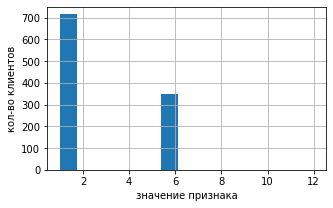

GROUP_VISITS


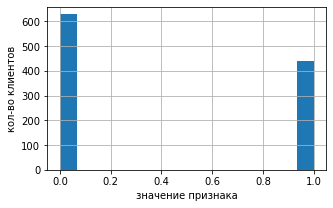

AGE


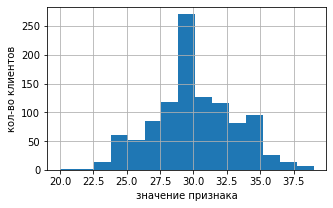

AVG_ADDITIONAL_CHARGES_TOTAL


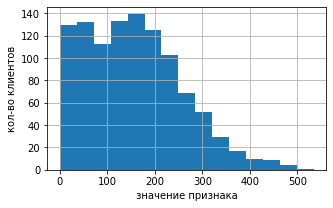

MONTH_TO_END_CONTRACT


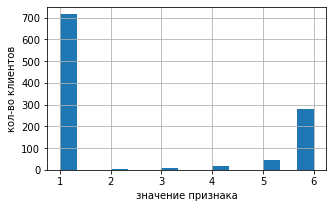

LIFETIME


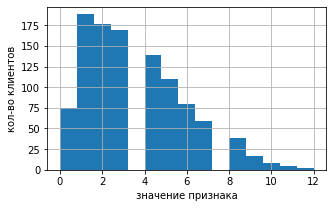

AVG_CLASS_FREQUENCY_TOTAL


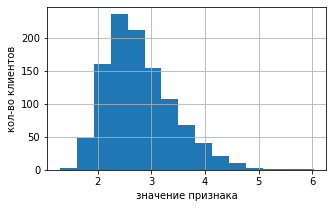

AVG_CLASS_FREQUENCY_CURRENT_MONTH


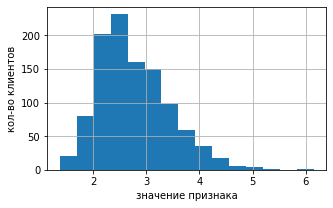

CHURN


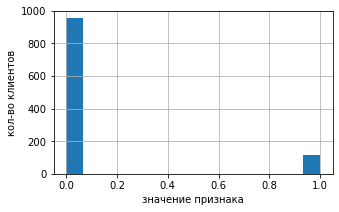

CLUSTER_KM


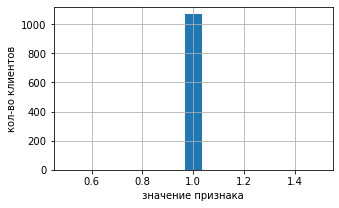

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
2,1,0,0.525708,0.848898,0.430220,0.295908,0.907660,2.748164,0.423924,30.272823,160.238659,2.627492,3.720881,2.815228,2.823357
3,1,1,0.504425,0.796460,0.327434,0.185841,0.902655,1.840708,0.300885,28.230088,129.325090,1.796460,0.946903,2.532596,2.345228


In [18]:
hist_func(df, 'cluster_km == 1')
df_grouped2_1 = df_grouped2.query('cluster_km == 1')
display(df_grouped2_1)

Выводы по кластеру 1
- распределение по полам отличается некритично;
- клиент в большинстве случаев живет в районе фитнес-центра;
- может быть как сотрудником компании-партнера, так и обычным клиентом, различия минимальны;
- в большинстве случаев приходит без использования промо-кода друзей;
- указывает номер телефона;
- в большинстве случаев берет абонемент на 1 или 6 мес;
- возраст 27 - 32 года;
- доп.траты у большинства клиентов до 160 у.е.;
- до окончания контракта в большинстве случаев осталось 1 мес;
- преобладающий lifetime от 1 до 5 мес;
- клиент ходит в зал 2-3 раза в неделю.

### Кластер 2

GENDER


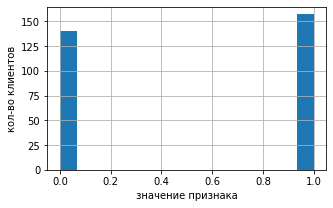

NEAR_LOCATION


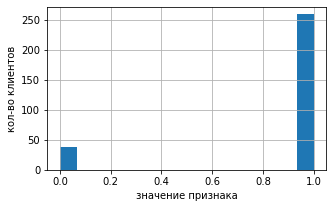

PARTNER


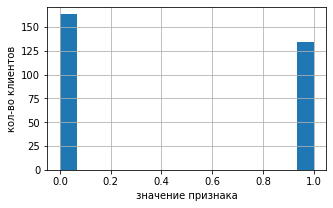

PROMO_FRIENDS


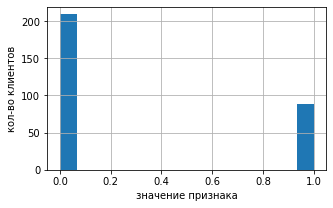

PHONE


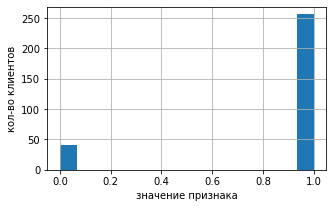

CONTRACT_PERIOD


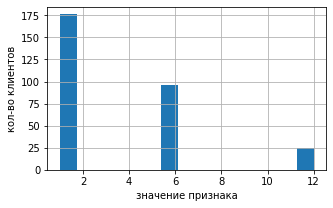

GROUP_VISITS


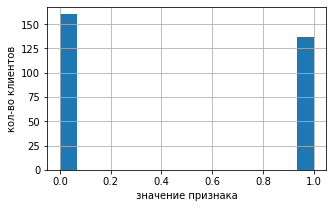

AGE


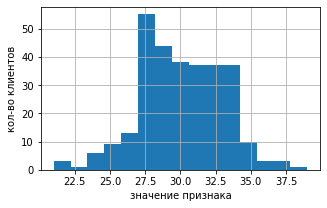

AVG_ADDITIONAL_CHARGES_TOTAL


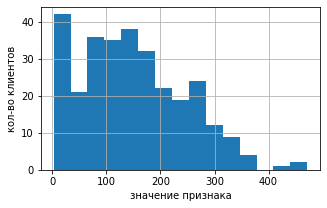

MONTH_TO_END_CONTRACT


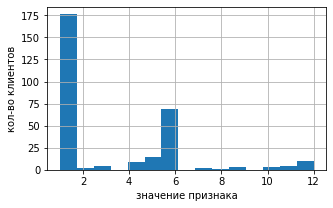

LIFETIME


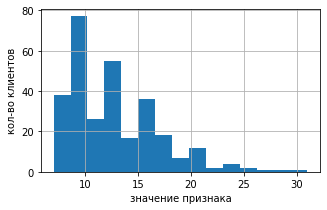

AVG_CLASS_FREQUENCY_TOTAL


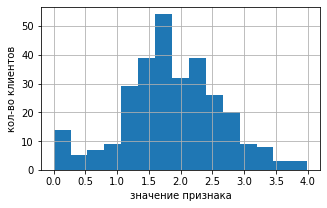

AVG_CLASS_FREQUENCY_CURRENT_MONTH


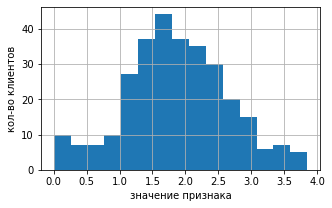

CHURN


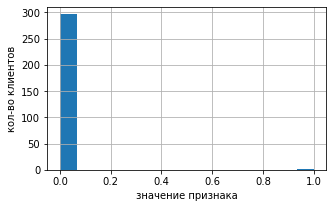

CLUSTER_KM


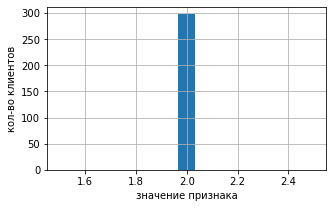

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
4,2,0,0.527027,0.871622,0.452703,0.297297,0.861486,3.550676,0.459459,29.976351,148.608957,3.222973,12.635135,1.856308,1.864625
5,2,1,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,33.000000,208.071672,1.000000,8.000000,1.974417,1.518766


In [19]:
hist_func(df, 'cluster_km == 2')
df_grouped2_2 = df_grouped2.query('cluster_km == 2')
display(df_grouped2_2)

Выводы по кластеру 2
- скорее обычный клиент, чем сотрудник, но разница незначительна;
- скорее приходит сам, чем по промокоду;
- указывает номер телефона;
- берет абонемент чаще на 1 мес.;
- возраст около 27-32 года;
- до окончания контракта в большинстве случаев осталось 1 мес.;
- много лояльных клиентов от 5 мес. от первого посещения;
- ходит 1-2 раза в неделю.

### Кластер 3

GENDER


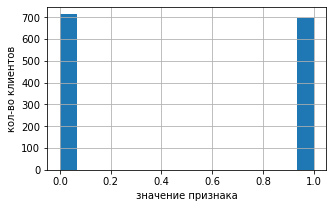

NEAR_LOCATION


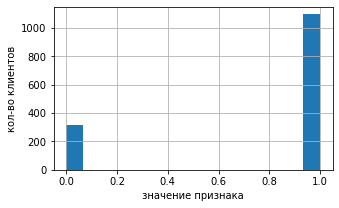

PARTNER


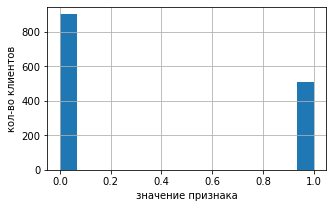

PROMO_FRIENDS


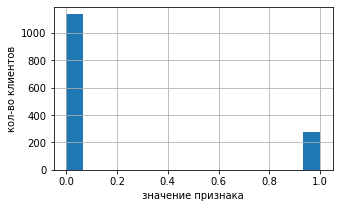

PHONE


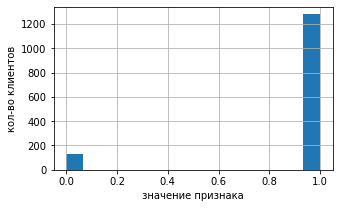

CONTRACT_PERIOD


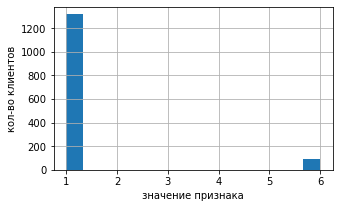

GROUP_VISITS


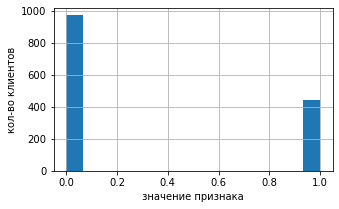

AGE


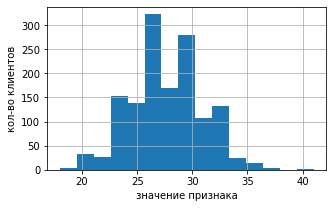

AVG_ADDITIONAL_CHARGES_TOTAL


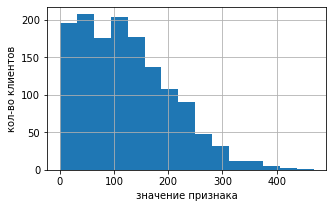

MONTH_TO_END_CONTRACT


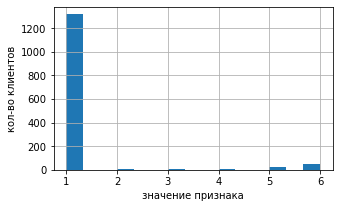

LIFETIME


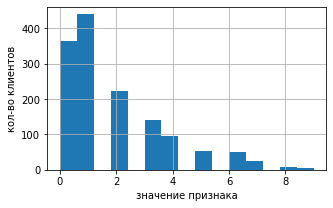

AVG_CLASS_FREQUENCY_TOTAL


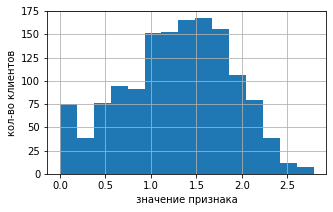

AVG_CLASS_FREQUENCY_CURRENT_MONTH


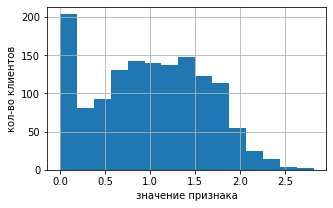

CHURN


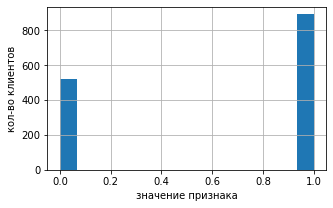

CLUSTER_KM


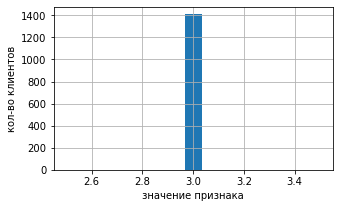

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
6,3,0,0.480695,0.810811,0.401544,0.23166,0.915058,1.395753,0.401544,29.318533,145.247090,1.305019,3.270270,1.164328,1.158573
7,3,1,0.502247,0.757303,0.337079,0.17191,0.902247,1.286517,0.259551,26.800000,111.377315,1.248315,0.983146,1.355323,0.896975


In [20]:
hist_func(df, 'cluster_km == 3')
df_grouped2_3 = df_grouped2.query('cluster_km == 3')
display(df_grouped2_3)

Выводы по кластеру 3
- клиент в большинстве случаев живет в районе фитнес-центра;
- скорее сотрудник компании-партнера, чем обычный клиент;
- в большинстве случаев приходит без использования промо-кода друзей;
- в большинстве случаев берет абонемент на 1 мес.;
- возраст 26 - 30 лет;
- до окончания контракта в большинстве случаев осталось 1 мес;
- новые пользователи - до 3 мес с даты первого посещения;
- ходит в зал до 2 раз в неделю;
- в текущем месяце кол-во посещений снижается, растет кол-во непосещающих пользователей.

### Кластер 4

GENDER


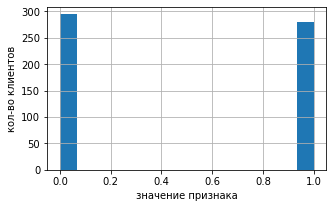

NEAR_LOCATION


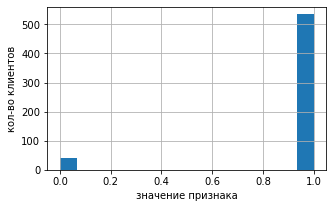

PARTNER


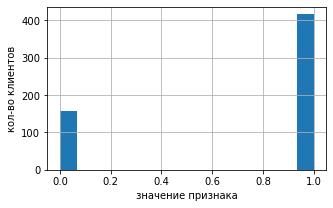

PROMO_FRIENDS


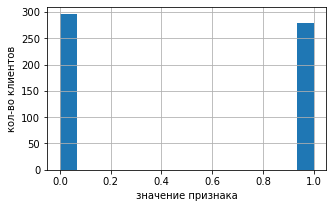

PHONE


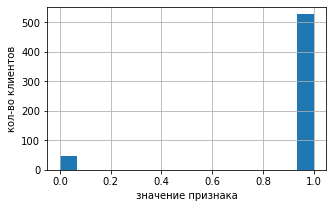

CONTRACT_PERIOD


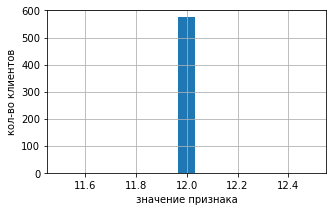

GROUP_VISITS


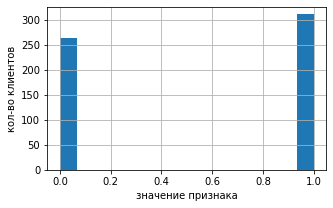

AGE


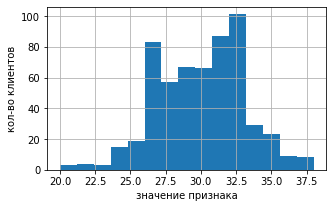

AVG_ADDITIONAL_CHARGES_TOTAL


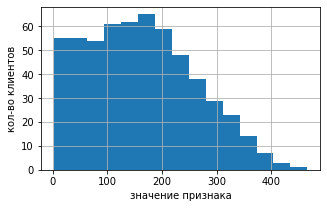

MONTH_TO_END_CONTRACT


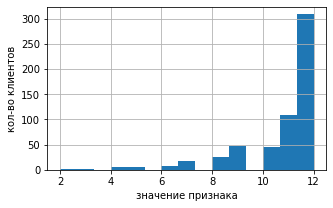

LIFETIME


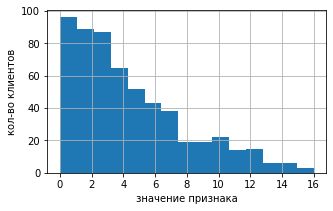

AVG_CLASS_FREQUENCY_TOTAL


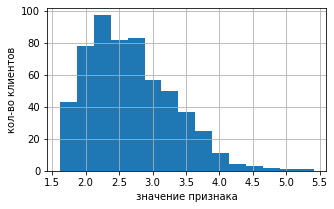

AVG_CLASS_FREQUENCY_CURRENT_MONTH


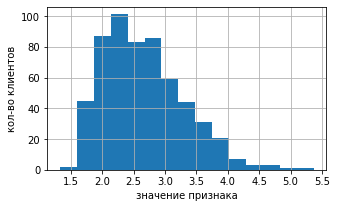

CHURN


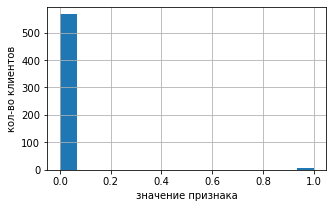

CLUSTER_KM


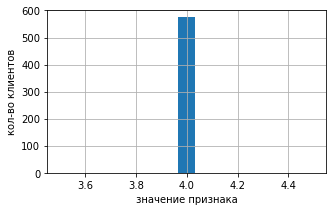

,cluster_km,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
8,4,0,0.485866,0.932862,0.724382,0.489399,0.916961,12.0,0.545936,29.952297,163.148591,10.80742,4.664311,2.675451,2.674803
9,4,1,0.625000,0.750000,0.750000,0.250000,0.875000,12.0,0.250000,25.750000,99.115188,10.62500,1.125000,2.402377,1.858820


In [21]:
hist_func(df, 'cluster_km == 4')
df_grouped2_3 = df_grouped2.query('cluster_km == 4')
display(df_grouped2_3)

Выводы по кластеру 4
- клиент в большинстве случаев живет в районе фитнес-центра;
- скорее сотрудник, чем обычный клиент;
- берет абонемент на 12 мес.;
- может как посещать, так и не посещать групповые занятия, различия минимальные;
- возраст от 26 до 30 лет;
- до окончания контракта в большинстве случаев осталось 10-12 мес;
- может быть как новым, так и старым клиентом, но большинство в диапазоне от 0 до 6 мес. от первого посещения;
- ходит в зал 2-3 раза в неделю- регулярно.


## Отток по кластерам

In [22]:
# размеры кластеров и доли
df_size = df.groupby(['cluster_km', 'Churn']).agg({'gender': 'count'})
df_size = df_size.reset_index()
# превращаем таблицу в строко-ориентированную
df_size = df_size.pivot_table(index = 'cluster_km', columns = 'Churn', values = 'gender', aggfunc = 'sum')
df_size = df_size.reset_index()
df_size.columns = ['cluster_km', 0, 1]

# высчитываем долю оттока кластера
df_size['churn_rate'] = df_size[1] / (df_size[0] + df_size[1])
display(df_size.sort_values(by = 'churn_rate', ascending = False))

,cluster_km,0,1,churn_rate
3,3,518,890,0.632102
1,1,953,113,0.106004
0,0,606,49,0.074809
4,4,566,8,0.013937
2,2,296,1,0.003367


В конченом итоге мы приходим к выводу, что кластер с самым большим оттоком - второй. Наименьший отток - во втором кластере.

## Вывод по кластеризации

На основе кластеризации и анализа признаков можно сделать вывод о том, что среди кластеров для "отваливающихся" пользователей преобладают следующие закономерности:

1. больше тех, кто живет не в районе центра;
2. больше тех, кто пришел сам, а не по промокоду;
3. длительность абонемента у выбывших ниже;
4. больше тех, кто не посещал групповые занятия;
5. тратят на доп.услуги меньше, чем оставшиеся;
6. падает частота посещений в неделю.

Для кластеров с маленьким оттоком характерно:
1. большее количество сотрудников компаний-партнеров;
2. Небольшой срок абонемента;
3. Длительный lifetime;
4. Частые посещения в течение месяца.

# Общий вывод

**Предобработка** прошла без проблем. В данных ошибок выявлено не было.

**При выборе модели** для обучения лучшей оказалась модель логистической регрессии при показателях `accuracy`, `precision` и `recall` - 0.90, 0.79 и 0.79 соответственно.

**В ходе кластеризации** был составлен портрет "типичного" выбывшего клиента:
- живет не в центре;
- стал клиентом сам, без промокода;
- низкая длительность абонемента по сравнению с оставшимися клиентами;
- мало посещал групповые занятия;
- тратит меньше денег на дополнительные услуги (!!!);
- редко ходит в зал.

## Рекомендации бизнесу

- таргетировать рекламу для живущих рядом с центром;
- рекламировать групповые занятия;
- рекламировать дополнительные услуги новым клиентам, предлагать скидки;
- предлагать выгодно продлевать абонемент;
- поддерживать и увеличивать количество посещений введением новых программ и услуг.